In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import copy
from datetime import datetime
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import PolynomialFeatures

In [2]:
file = '/Users/kiening/Documents/Dissertation/dissertation.cb_companies.json'

with open(file, 'r', encoding='utf-8') as file:
    data = json.load(file)


In [43]:
data[0]

{'_id': {'$oid': '667d505273f74a2b87f0bd5b'},
 'uuid': '8bb75a65-0355-003b-5f58-2f437e83a55a',
 'categories': ['Agriculture',
  'Artificial Intelligence (AI)',
  'Big Data',
  'Data Visualization',
  'Information Technology',
  'SaaS'],
 'category_groups': ['Agriculture and Farming',
  'Artificial Intelligence (AI)',
  'Data and Analytics',
  'Design',
  'Information Technology',
  'Science and Engineering',
  'Software'],
 'cb_created_at': '2014-06-05T06:08:29Z',
 'cb_updated_at': '2021-07-28T15:33:13Z',
 'created_at': {'$date': '2024-06-27T12:43:14.329Z'},
 'equity_funding_total_usd': 114700000,
 'facet_ids': ['company', 'rank'],
 'founded_on': '2014-01-01',
 'founders': ['Isabel Schoeps'],
 'funding_stage': 'early_stage_venture',
 'funding_total_usd': 117609000,
 'investor_stage': [],
 'investors': ['Notable Capital',
  'DCVC',
  'TPG Growth',
  'One Planet Group',
  'EchoVC Partners'],
 'last_equity_funding_total_usd': 85000000,
 'last_equity_funding_type': 'series_b',
 'last_fundi

In [3]:
def whether_success(companies):
    for i in companies:
        i['startup'] = 'failed'
        if i['operating_status'] != 'closed':
            if i['went_public_on']:
                i['startup'] = 'success'
            elif i['status'] == 'was_acquired' or i['status'] == 'ipo':
                i['startup'] = 'success'
            elif (datetime.now() - datetime.strptime(i['founded_on'], '%Y-%m-%d')).days/365 >= 7:
                i['startup'] = 'success'
            elif i['num_funding_rounds'] >= 7:
                i['startup'] = 'success'
            elif i['equity_funding_total_usd'] >= 100000000:
                i['startup'] = 'success'
    return companies

In [4]:
def build_nw(comps, peo):
    G = nx.Graph()
    G.add_nodes_from(comps)
    
    peo_dict = {comp: set(p) for comp, p in zip(comps, peo)}
    
    def process_pairs(i, comp):
        edges = []
        for j in range(i+1, len(comps)):
            same = peo_dict[comp] & peo_dict[comps[j]]
            if same:
                edges.append((comp, comps[j], len(same)))
        return edges

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_pairs, i, comp) for i, comp in enumerate(comps)]
        for future in as_completed(futures):
            for comp1, comp2, weight in future.result():
                if G.has_edge(comp1, comp2):
                    G[comp1][comp2]['weight'] += weight
                else:
                    G.add_edge(comp1, comp2, weight=weight)

    return G


In [5]:
def data_pre(companies):
    for i in companies:
        if 'metadata' in i.keys():
            del i['metadata']
        comp_name = i['name']
        i['name'] = f"{comp_name}_{companies.index(i)}"
        if not isinstance(i['equity_funding_total_usd'], int):
            value = i['equity_funding_total_usd']
            i['equity_funding_total_usd'] = int(value['$numberLong'])
        if i['num_funding_rounds'] is None:
            i['num_funding_rounds'] = 0
    return companies

In [122]:
def success_rate(data, dict, field):
    result = {}
    for i in dict:
        result[i] = 0
        for n in data:
            if isinstance(n[field], list):
                if i in n[field] and n['startup'] == 'success':
                    result[i] += 1
            else:
                if n[field] == i and n['startup'] == 'success':
                    result[i] += 1
    for k in result:
        result[k] = result[k]/dict[k]
    return result

In [169]:
def components_data(G):
    result = {}
    for component in nx.connected_components(G):
        subgraph = G.subgraph(component)
        sub_size = len(subgraph)
        sub_success = 0
        for node in subgraph:
            if G.nodes[node]['success'] == 'success':
                sub_success += 1
        sub_success_rate = sub_success/sub_size
        for node in subgraph:
            result[node] = {'component_size': sub_size, 'component_success_rate': sub_success_rate}
    return result

In [ ]:
data_test = copy.deepcopy(data)
data_test = whether_success(data_pre(data_test))

In [105]:
data_test[0]

{'_id': {'$oid': '667d505273f74a2b87f0bd5b'},
 'uuid': '8bb75a65-0355-003b-5f58-2f437e83a55a',
 'categories': ['Agriculture',
  'Artificial Intelligence (AI)',
  'Big Data',
  'Data Visualization',
  'Information Technology',
  'SaaS'],
 'category_groups': ['Agriculture and Farming',
  'Artificial Intelligence (AI)',
  'Data and Analytics',
  'Design',
  'Information Technology',
  'Science and Engineering',
  'Software'],
 'cb_created_at': '2014-06-05T06:08:29Z',
 'cb_updated_at': '2021-07-28T15:33:13Z',
 'created_at': {'$date': '2024-06-27T12:43:14.329Z'},
 'equity_funding_total_usd': 114700000,
 'facet_ids': ['company', 'rank'],
 'founded_on': '2014-01-01',
 'founders': ['Isabel Schoeps'],
 'funding_stage': 'early_stage_venture',
 'funding_total_usd': 117609000,
 'investor_stage': [],
 'investors': ['Notable Capital',
  'DCVC',
  'TPG Growth',
  'One Planet Group',
  'EchoVC Partners'],
 'last_equity_funding_total_usd': 85000000,
 'last_equity_funding_type': 'series_b',
 'last_fundi

In [ ]:
# Read data here
comps = []
peo = []

for com in data:
    comps.append(com['name'])
    peo.append(list(set(com['founders']) | set(com['investors'])))

unique_comps = [f"{comp}_{i}" for i, comp in enumerate(comps)]

In [ ]:
len(comps)

In [86]:
fea_select = pd.DataFrame(data_test)
X_fea_select = fea_select.drop(columns=['startup','_id','uuid','cb_created_at','cb_updated_at','created_at','facet_ids','short_description','updated_at','version','owner','exited_on'])
y_fea_select = fea_select['startup']

X_train, X_test, y_train, y_test = train_test_split(X_fea_select, y_fea_select, test_size=0.3, random_state=42)

# 训练随机森林模型
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 计算特征重要性
feature_importances = model.feature_importances_

# 创建一个包含特征和对应重要性的DataFrame
features = X_fea_select.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# 按重要性排序
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 输出排序后的特征重要性
print(importance_df)

ValueError: setting an array element with a sequence.

In [ ]:
G = build_nw(unique_comps, peo)

In [152]:
len(data_test)

79093

In [ ]:
node_attri = {}
for index, node in enumerate(G.nodes()):
    node_attri[node] = {}
    node_attri[node]['categories'] = data_test[index]['category_groups']
    node_attri[node]['success'] = data_test[index]['startup']
nx.set_node_attributes(G, node_attri)


In [ ]:
isolates = list(nx.isolates(G))

In [10]:
len(isolates)

28950

In [ ]:
iso_comps = []
found_on = []
funding = []
rounds = []
startup = []
for i in range(len(unique_comps)):
    if unique_comps[i] in isolates:
        iso_comps.append(data_test[i]['name'])
        found_on.append((datetime.now() - datetime.strptime(data_test[i]['founded_on'], '%Y-%m-%d')).days)
        funding.append(data_test[i]['equity_funding_total_usd'])
        rounds.append(data_test[i]['num_funding_rounds'])
        startup.append(data_test[i]['startup'])
iso_df = pd.DataFrame({
    'company': iso_comps,
    'days_since_founded': found_on,
    'equity_funding_total_usd': funding,
    'num_funding_rounds': rounds,
    'startup': startup
})
iso_df['num_funding_rounds'] = iso_df['num_funding_rounds'].fillna(0)

In [ ]:
iso_df

In [ ]:
print(iso_df.describe())

In [ ]:
data_non_iso = [i for i in data_test if i['name'] not in isolates]

In [110]:
len(data_non_iso)

71050

In [14]:
# Use Random forests to judge feature importance
X = iso_df.drop(columns=['startup', 'company'])
y = iso_df['startup']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalized
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Feature importance
feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Rank
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                    Feature  Importance
0        days_since_founded    0.812514
1  equity_funding_total_usd    0.171733
2        num_funding_rounds    0.015752


In [15]:
# Recursive feature elimination to judge feature importance
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=1)
rfe.fit(X_train, y_train)

# Rank
ranking = rfe.ranking_
ranking_df = pd.DataFrame({'Feature': features, 'Ranking': ranking})
ranking_df = ranking_df.sort_values(by='Ranking')
print(ranking_df)

                    Feature  Ranking
0        days_since_founded        1
2        num_funding_rounds        2
1  equity_funding_total_usd        3


In [16]:
# MI to judge feature importance
mi = mutual_info_classif(X_train, y_train)

# Rank
mi_df = pd.DataFrame({'Feature': features, 'Mutual Information': mi})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)
print(mi_df)

                    Feature  Mutual Information
0        days_since_founded            0.382190
1  equity_funding_total_usd            0.017737
2        num_funding_rounds            0.008321


In [17]:
# Feature combination
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model_poly = RandomForestClassifier(random_state=42)
model_poly.fit(X_train_poly, y_train)

# Performance
y_pred = model_poly.predict(X_test_poly)
print("Classification Report with Interaction Features:")
print(classification_report(y_test, y_pred))

Classification Report with Interaction Features:
              precision    recall  f1-score   support

      failed       0.89      0.84      0.87      2386
     success       0.89      0.93      0.91      3404

    accuracy                           0.89      5790
   macro avg       0.89      0.88      0.89      5790
weighted avg       0.89      0.89      0.89      5790



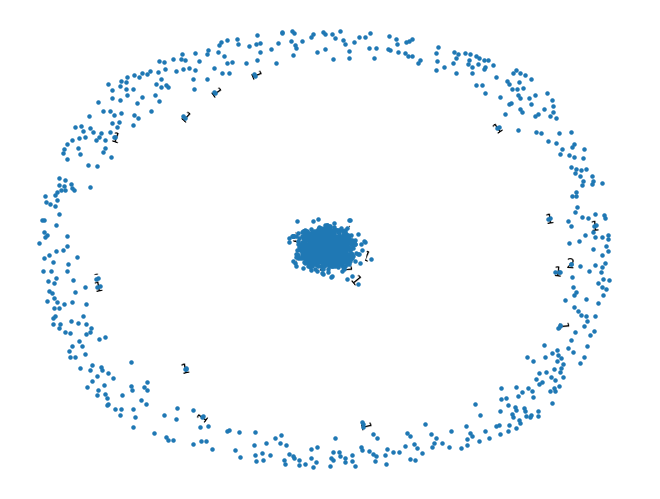

In [40]:
# Draw network here
#nx.draw(G, with_labels=True)

pos = nx.spring_layout(G)
nx.draw(G, 
        pos, 
        with_labels=False, 
        node_size=5, 
        font_size=5)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()


In [24]:
len(G.edges)

10499381

In [ ]:
def generate_data(G):
    net_nodes = len(G.nodes())
    net_edges = len(G.edges())
    net_den = round(nx.density(G),4)
    avg_cluster = round(nx.average_clustering(G),4)
    avg_degree = round(np.mean(list(dict(G.degree()).values())),4)
    max_degree = max(list(dict(G.degree()).values()))
    min_degree = min(list(dict(G.degree()).values()))
    total_strength = 0
    for node in G.nodes():
        node_strength = sum(data["weight"] for u, v, data in G.edges(node, data=True))
        total_strength += node_strength
    avg_strength = round(total_strength / net_nodes, 4)
    try:
        net_assortativity = round(nx.degree_assortativity_coefficient(G),4)
    except RuntimeWarning:
        net_assortativity = None

    table ={
        "Number of Nodes": net_nodes,
        "Number of Edges": net_edges,
        "Density": net_den,
        "Avg Clustering Coefficient": avg_cluster,
        "Avg Degree": avg_degree,
        "Max Degree": max_degree,
        "Min Degree": min_degree,
        "Avg Strength": avg_strength,
        "Assortativity": net_assortativity}    
    return table

In [ ]:
analysis = generate_data(G)
analysis

In [22]:
data[1].keys()

dict_keys(['_id', 'uuid', 'categories', 'category_groups', 'cb_created_at', 'cb_updated_at', 'created_at', 'equity_funding_total_usd', 'facet_ids', 'founded_on', 'founders', 'funding_stage', 'funding_total_usd', 'investor_stage', 'investors', 'last_equity_funding_total_usd', 'last_equity_funding_type', 'last_funding_date', 'last_funding_total_usd', 'last_funding_type', 'location_groups', 'locations', 'name', 'num_acquisitions', 'num_employees_enum', 'num_funding_rounds', 'operating_status', 'owner', 'rank_org', 'rank_principal', 'revenue_range', 'short_description', 'status', 'updated_at', 'valuation_usd', 'version', 'exited_on', 'investor_type', 'went_public_on', 'startup'])

In [ ]:
def generate_feature(G, data):
    degrees = dict(G.degree())
    # clustering = nx.clustering(G)
    closeness = nx.closeness_centrality(G)
    # betweenness = nx.betweenness_centrality(G)
    # eigenvector_centrality = nx.eigenvector_centrality(G)
    # pagerank = nx.pagerank(G)
    
    nodes = [node for node in G.nodes() if node not in list(nx.isolates(G))]
    data = {
        'node_id': nodes,
        'degree': [degrees[node] for node in nodes],
        # 'clustering': [clustering[node] for node in nodes],
        'closeness': [closeness[node] for node in nodes],
        # 'betweenness': [betweenness[node] for node in nodes],
        # 'closeness': [closeness[node] for node in nodes],
        # 'eigenvector_centrality': [eigenvector_centrality[node] for node in nodes],
        # 'pagerank': [pagerank[node] for node in nodes],
        'categories': [comp['category_groups'] for comp in data if comp['name'] not in list(nx.isolates(G))]
    }
    df = pd.DataFrame(data)
    return df

In [ ]:
fea_df = generate_feature(G, data_test)

In [ ]:
fea_df

In [ ]:
cla = {}
for i in data_non_iso:
    for n in i['category_groups']:
        if not n in cla.keys():
            cla[n] = 1
        else:
            cla[n] += 1
cla_success_rate = success_rate(data_non_iso, cla, 'category_groups')
cla_avg_closeness = {}
for i in cla.keys():
    for n in range(len(fea_df['node_id'])):
        if i in fea_df['categories'][n]:
            if i in cla_avg_closeness:
                cla_avg_closeness[i] += fea_df['closeness'][n]
            else:
                cla_avg_closeness[i] = fea_df['closeness'][n]
for i in cla_avg_closeness:
    cla_avg_closeness[i] = cla_avg_closeness[i]/cla[i]


avg_cla_sco = []
avg_cla_clo = []
for i in fea_df['categories']:
    cla_rates = [cla_success_rate[n] for n in i]
    clo_rates = [cla_avg_closeness[n] for n in i]
    if cla_rates:
        avg_success_rate = sum(cla_rates) / len(cla_rates)
        avg_clo = sum(clo_rates) / len(clo_rates)
        avg_cla_sco.append(avg_success_rate)
        avg_cla_clo.append(avg_clo)
    else:
        avg_cla_sco.append(0)
        avg_cla_clo.append(0)
fea_df['class_score'] = avg_cla_sco
fea_df['class_avg_closeness'] = avg_cla_clo

In [ ]:
location = {}
for i in data_non_iso:
    if i['location_groups']:
        for n in i['location_groups']:
            if not n in location:
                location[n] = 1
            else:
                location[n] += 1
loc_success_rate = success_rate(data_non_iso, location, 'location_groups')
avg_loc_sco = []
for i in data_non_iso:
    rates = [loc_success_rate[n] for n in i['location_groups']]
    if rates:
        avg_success_rate = sum(rates) / len(rates)
        avg_loc_sco.append(avg_success_rate)
    else:
        avg_loc_sco.append(0)
fea_df['location_score'] = avg_loc_sco

In [ ]:
employees = {}
for i in data_non_iso:
    if i['num_employees_enum']:
        if not i['num_employees_enum'] in employees:
            employees[i['num_employees_enum']] = 1
        else:
            employees[i['num_employees_enum']] += 1
emp_success_rate = success_rate(data_non_iso, employees, 'num_employees_enum')
avg_emp_sco = []
for i in data_non_iso:
    if i['num_employees_enum']:
        avg_emp_sco.append(emp_success_rate[i['num_employees_enum']])
    else:
        avg_emp_sco.append(0)
fea_df['employees_score'] = avg_emp_sco

In [ ]:
node_component_data = components_data(G)
comp_success_rate = [node_component_data[node]['component_success_rate'] for node in fea_df['node_id']]
comp_size = [node_component_data[node]['component_size'] for node in fea_df['node_id']]
fea_df['component_success_rate'] = comp_success_rate
fea_df['component_size'] = comp_size

In [27]:
X = fea_df[fea_df['categories'].apply(lambda x: 'Software' in x)][['degree', 'closeness', 'clustering', 'betweenness', 'eigenvector_centrality', 'pagerank']]
y = [i['startup'] for i in data_test if 'Software' in i['category_groups'] and i['name'] not in list(nx.isolates(G))]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [181]:
X = fea_df.drop(columns=['node_id', 'categories', 'component_size'])
y = [i['startup'] for i in data_non_iso]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [182]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [174]:
# MI to judge feature importance
features = X.columns
mi = mutual_info_classif(X_train, y_train)

# Rank
mi_df = pd.DataFrame({'Feature': features, 'Mutual Information': mi})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)
print(mi_df)

                  Feature  Mutual Information
4         employees_score            0.018185
6  component_success_rate            0.017945
1               closeness            0.013029
5     class_avg_closeness            0.012501
7          component_size            0.008253
2             class_score            0.008217
3          location_score            0.007060
0                  degree            0.002380


In [183]:

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Feature importance
feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Rank
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                  Feature  Importance
1               closeness    0.237367
2             class_score    0.198449
0                  degree    0.197163
5     class_avg_closeness    0.189360
3          location_score    0.111617
4         employees_score    0.044833
6  component_success_rate    0.021211


In [ ]:
# Recursive feature elimination to judge feature importance
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=1)
rfe.fit(X_train, y_train)

# Rank
ranking = rfe.ranking_
ranking_df = pd.DataFrame({'Feature': features, 'Ranking': ranking})
ranking_df = ranking_df.sort_values(by='Ranking')
print(ranking_df)

In [39]:
X_train

array([[-0.53849558, -1.4387073 ],
       [-0.0644915 ,  0.49656326],
       [ 1.4534282 ,  0.54926029],
       ...,
       [-0.52189622, -0.04050087],
       [-0.00731591,  0.69545495],
       [-0.53849558, -3.93060599]])

In [184]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model_1 = LogisticRegression(max_iter=1000)
model_2 = DecisionTreeClassifier()
model_3 = RandomForestClassifier()
model_4 = SVC(kernel='linear', probability=True)
model_5 = KNeighborsClassifier(n_neighbors=3)

model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
model_4.fit(X_train, y_train)
model_5.fit(X_train, y_train)

y_pred_1 = model_1.predict(X_test)
y_pred_2 = model_2.predict(X_test)
y_pred_3 = model_3.predict(X_test)
y_pred_4 = model_4.predict(X_test)
y_pred_5 = model_5.predict(X_test)

model_1_poly = LogisticRegression()
model_2_poly = DecisionTreeClassifier()
model_3_poly = RandomForestClassifier()
model_4_poly = SVC(kernel='linear', probability=True)
model_5_poly = KNeighborsClassifier(n_neighbors=3)

model_1_poly.fit(X_train_poly, y_train)
model_2_poly.fit(X_train_poly, y_train)
model_3_poly.fit(X_train_poly, y_train)
model_4_poly.fit(X_train_poly, y_train)
model_5_poly.fit(X_train_poly, y_train)

y_pred_1_poly = model_1_poly.predict(X_test_poly)
y_pred_2_poly = model_2_poly.predict(X_test_poly)
y_pred_3_poly = model_3_poly.predict(X_test_poly)
y_pred_4_poly = model_4_poly.predict(X_test_poly)
y_pred_5_poly = model_5_poly.predict(X_test_poly)

/Users/kiening/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [185]:
def evaluate_pred(model, X_test, y_test, y_pred, model_name):
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    
    if y_proba is not None:
        roc_auc = roc_auc_score(y_test, y_proba)
        print(f"{model_name} ROC AUC Score: {roc_auc:.3f}")
    else:
        print(f"{model_name} does not provide probability predictions for ROC AUC Score.")

In [186]:
evaluate_pred(model_1, X_test, y_test, y_pred_1, 'Logistic Regression')
evaluate_pred(model_2, X_test, y_test, y_pred_2, 'Decision Tree')
evaluate_pred(model_3, X_test, y_test, y_pred_3, 'Random Forest')
evaluate_pred(model_4, X_test, y_test, y_pred_4, 'SVC')
evaluate_pred(model_5, X_test, y_test, y_pred_5, 'K-Nearest Neighbors')
print('*******************************************')
evaluate_pred(model_1_poly, X_test_poly, y_test, y_pred_1_poly, 'Logistic Regression with Interaction Features')
evaluate_pred(model_2_poly, X_test_poly, y_test, y_pred_2_poly, 'Decision Tree with Interaction Features')
evaluate_pred(model_3_poly, X_test_poly, y_test, y_pred_3_poly, 'Random Forest with Interaction Features')
evaluate_pred(model_4_poly, X_test_poly, y_test, y_pred_4_poly, 'SVC with Interaction Features')
evaluate_pred(model_5_poly, X_test_poly, y_test, y_pred_5_poly, 'K-Nearest Neighbors with Interaction Features')

Logistic Regression Classification Report:
              precision    recall  f1-score   support

      failed       0.57      0.09      0.15      5179
     success       0.65      0.96      0.77      9031

    accuracy                           0.64     14210
   macro avg       0.61      0.52      0.46     14210
weighted avg       0.62      0.64      0.55     14210

Logistic Regression ROC AUC Score: 0.634
Decision Tree Classification Report:
              precision    recall  f1-score   support

      failed       0.41      0.42      0.42      5179
     success       0.66      0.65      0.66      9031

    accuracy                           0.57     14210
   macro avg       0.54      0.54      0.54     14210
weighted avg       0.57      0.57      0.57     14210

Decision Tree ROC AUC Score: 0.536
Random Forest Classification Report:
              precision    recall  f1-score   support

      failed       0.49      0.33      0.39      5179
     success       0.68      0.80      0.73 